In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [2]:
### READ DATA ###

df = pd.read_csv('car_lemon.csv.zip')

print(df.shape)
df.head()

(72983, 34)


,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


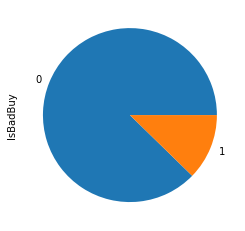

In [3]:
### LABEL DISTRIBUTION ###

df.IsBadBuy.value_counts().plot.pie()

In [4]:
### ENCODE LABELS ###

label = pd.get_dummies(df.IsBadBuy).values

df.drop(['RefId','IsBadBuy','PurchDate'], inplace=True, axis=1)

In [5]:
### ADJUST DATA AND SEPARATE NUMERICAL FROM CATEGORICAL VARIABLES ###

cat_ = {}
num_ = {}
nans = df.isna().sum() / len(df)

for col in df.columns:
    
    if nans[col] > 0:
        
        if (df.dtypes[col] == float) or (df.dtypes[col] == int):
            
            df[col].fillna(df[col].median(), inplace=True)
            num_[col] = df[col].std()
            
        else:
            
            df[col].fillna('unknown', inplace=True)
            
            encoder = LabelEncoder()
            df[col] = encoder.fit_transform(df[col])
            cat_[col] = df[col].max()

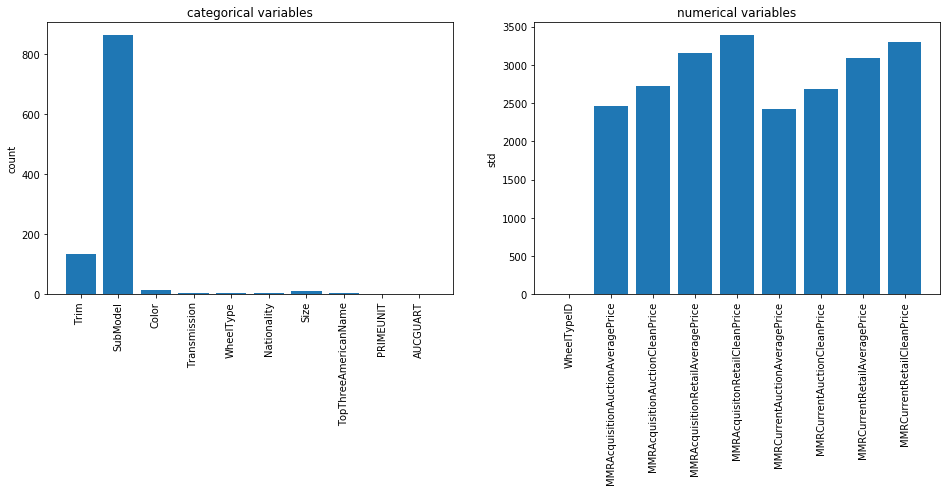

In [6]:
### PLOT DESCRIPTIVE STATISTICS OF DATASET ###

plt.figure(figsize=(16, 5))

plt.subplot(121)
plt.bar(range(len(cat_)), cat_.values())
plt.xticks(range(len(cat_)), cat_.keys(), rotation=90)
plt.ylabel('count'); plt.title('categorical variables')

plt.subplot(122)
plt.bar(range(len(num_)), num_.values())
plt.xticks(range(len(num_)), num_.keys(), rotation=90)
plt.ylabel('std'); plt.title('numerical variables')

np.set_printoptions(False)

In [7]:
### TRAIN, VALIDATION, TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.4, random_state=33)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=33)

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(43789, 31) (14597, 31) (14597, 31)
(43789, 2) (14597, 2) (14597, 2)


In [8]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model(cat_feat, emb_dim=8):
    
    set_seed(33)
    
    def get_embed(inp, size, emb_dim, name):

        emb = Embedding(size, emb_dim)(inp)
        emb = Flatten(name=name)(emb)

        return emb
    
    inp_dense = Input(shape=len(num_))
    
    embs, inps = [], [inp_dense]
    
    x = Dense(128, activation='relu')(inp_dense)
    
    for f in cat_feat:
        inp = Input((1,), name=f+'_inp')
        embs.append(get_embed(inp, cat_[f]+1, emb_dim, f))
        inps.append(inp)
        
    x = Concatenate()([x]+embs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    
    logits = Dense(2, name='logits')(x)
    out = Activation('softmax')(logits)
    
    model = Model(inps, out)
    model.compile(optimizer='adam', loss ='categorical_crossentropy', 
                  metrics=[tf.keras.metrics.AUC()])
    
    return model

In [9]:
model = get_model(list(cat_.keys()), emb_dim=8)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Trim_inp (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
SubModel_inp (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
Color_inp (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
Transmission_inp (InputLayer)   [(None, 1)]          0                                            
______________________________________________________________________________________________

In [10]:
### SCALE NUMERICA FEATURES ###

scaler = StandardScaler()
X_train_dense = scaler.fit_transform(X_train[num_.keys()])
X_valid_dense = scaler.transform(X_valid[num_.keys()])
X_test_dense = scaler.transform(X_test[num_.keys()])

In [11]:
es = EarlyStopping(patience=10, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

model = get_model(list(cat_.keys()), emb_dim=8)
model.fit([X_train_dense]+[X_train[f].values for f in cat_.keys()], y_train, epochs=30, batch_size=128,
          verbose=1, callbacks=[es], validation_data=([X_valid_dense]+[X_valid[f].values for f in cat_.keys()], y_valid))

Train on 43789 samples, validate on 14597 samples
Epoch 1/30
43789/43789 [==============================] - 4s 82us/sample - loss: 0.3687 - auc_1: 0.9102 - val_loss: 0.3673 - val_auc_1: 0.9214
Epoch 2/30
43789/43789 [==============================] - 2s 37us/sample - loss: 0.3269 - auc_1: 0.9245 - val_loss: 0.3362 - val_auc_1: 0.9265
Epoch 3/30
43789/43789 [==============================] - 2s 36us/sample - loss: 0.3191 - auc_1: 0.9278 - val_loss: 0.3223 - val_auc_1: 0.9279
Epoch 4/30
43789/43789 [==============================] - 2s 37us/sample - loss: 0.3142 - auc_1: 0.9303 - val_loss: 0.3199 - val_auc_1: 0.9289
Epoch 5/30
43789/43789 [==============================] - 2s 35us/sample - loss: 0.3124 - auc_1: 0.9314 - val_loss: 0.3240 - val_auc_1: 0.9257
Epoch 6/30
43789/43789 [==============================] - 2s 35us/sample - loss: 0.3106 - auc_1: 0.9322 - val_loss: 0.3188 - val_auc_1: 0.9290
Epoch 7/30
43789/43789 [==============================] - 1s 33us/sample - loss: 0.3079 - au

In [12]:
### PREDICT TEST DATA ###

pred_test = model.predict([X_test_dense]+[X_test[f].values for f in cat_.keys()])

In [13]:
### ACCURACY DUMMY CLASSIFIER: ALWAYS GOOD DEAL ###

y_test[:,0].sum()/len(y_test)

0.8747687881071453

In [14]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_test, axis=1)))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     12769
           1       0.79      0.26      0.39      1828

    accuracy                           0.90     14597
   macro avg       0.85      0.62      0.67     14597
weighted avg       0.89      0.90      0.88     14597



In [15]:
### CALCULATE RELIABILITY DIAGRAM ON TEST ###

acc_before = {}
prob_before = {}

for i in range(y_test.shape[1]):
    
    acc_before[i], prob_before[i] = calibration_curve(y_prob=pred_test[:, i], y_true=y_test[:, i], 
                                                      n_bins=10, normalize=True)

Text(0.5, 0, 'probabilities')

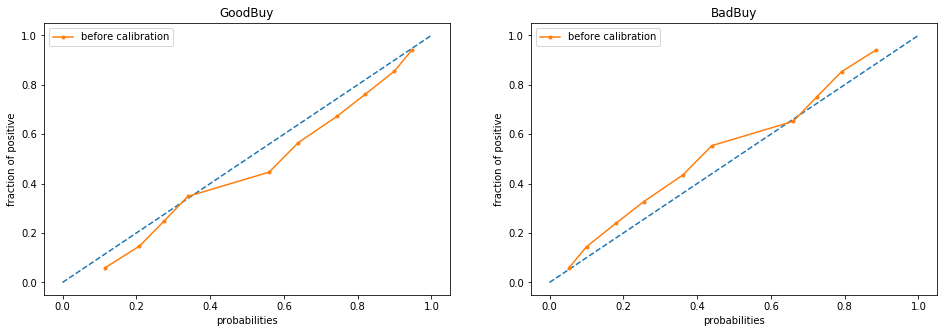

In [16]:
### PLOT RELIABILITY DIAGRAM ###

plt.figure(figsize=(16,5))

plt.subplot(121)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(acc_before[0], prob_before[0], marker='.', label='before calibration')
plt.legend(); plt.title('GoodBuy'); plt.ylabel('fraction of positive'); plt.xlabel('probabilities')

plt.subplot(122)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(acc_before[1], prob_before[1], marker='.', label='before calibration')
plt.legend(); plt.title('BadBuy'); plt.ylabel('fraction of positive'); plt.xlabel('probabilities')

In [17]:
### DEFINE ECE SCORE UTILITY FUNCTION ###

def ece_score(probabilities, accuracy, confidence):   
    
    n_bins = len(accuracy) 
    n = len(probabilities) 
    h = np.histogram(a=probabilities, range=(0, 1), bins=n_bins)[0]  
    
    ece = 0
    for m in np.arange(n_bins):
        ece = ece + (h[m] / n) * np.abs(accuracy[m] - confidence[m])
        
    return ece

In [18]:
### ECE SCORE FOR GOOD BUY ###

ece_score(pred_test[:,0], acc_before[0], prob_before[0])

0.028918922450637662

In [19]:
### ECE SCORE FOR BAD BUY ###

ece_score(pred_test[:,1], acc_before[1], prob_before[1])

0.028918907093476755

# NEURAL NETWORK CALIBRATION

In [20]:
### DEFINE UTILITY FUNCTIONS FOR FITTING TEMPERATURE SCALING AND CALIBRATE PROBABILITIES ###

def fit_TemperatureCalibration(train_X_y, valid_X_y=None, epochs=100):
    
    ### inspired by: https://github.com/stellargraph/stellargraph/blob/develop/stellargraph/calibration.py ###
    
    T = tf.Variable(tf.ones(shape=(1,)))
    history = []
    early_stopping = False
    optimizer = Adam(learning_rate=0.001)
    
    def cost(T, x, y):

        scaled_logits = tf.multiply(x=x, y=1.0 / T)

        cost_value = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(logits=scaled_logits, labels=y)
        )

        return cost_value

    def grad(T, x, y):

        with tf.GradientTape() as tape:
            cost_value = cost(T, x, y)

        return cost_value, tape.gradient(cost_value, T)
    
    
    X_train, y_train = train_X_y
    if valid_X_y:
        X_valid, y_valid = valid_X_y
        early_stopping = True
    
    
    for epoch in range(epochs):
        train_cost, grads = grad(T, X_train, y_train)
        optimizer.apply_gradients(zip([grads], [T]))
        if early_stopping:
            val_cost = cost(T, X_valid, y_valid)
            if (len(history) > 0) and (val_cost > history[-1][1]):
                break
            else: 
                history.append([train_cost, val_cost, T.numpy()[0]])
        else:
            history.append([train_cost, T.numpy()[0]])

    history = np.asarray(history)
    temperature = history[-1, -1]
    
    return temperature


def calibrated_proba(logits, temperature):
    
    scaled_prediction = logits / temperature

    return np.exp(scaled_prediction) / np.sum(np.exp(scaled_prediction), axis=-1, keepdims=True)

In [21]:
### SPLIT VALIDATION IN TRAIN AND TEST FOR CALIBRATION ###

X_train_calib, X_valid_calib, y_train_calib, y_valid_calib = train_test_split(X_valid, y_valid, test_size=0.2, random_state=33)

print(X_train_calib.shape, X_valid_calib.shape)
print(y_train_calib.shape, y_valid_calib.shape)

(11677, 31) (2920, 31)
(11677, 2) (2920, 2)


In [22]:
### STANDARDIZE DATA FOR CALIBRATION ###

X_train_calib_dense = scaler.transform(X_train_calib[num_.keys()])
X_valid_calib_dense = scaler.transform(X_valid_calib[num_.keys()])

In [23]:
### BUILD LOGITS EXTRACTOR ###

model_score = Model(model.input, model.get_layer('logits').output)

In [24]:
### EXTRACT LOGITS ###

X_train_calib = model_score.predict([X_train_calib_dense]+[X_train_calib[f].values for f in cat_.keys()])
X_valid_calib = model_score.predict([X_valid_calib_dense]+[X_valid_calib[f].values for f in cat_.keys()])

print(X_train_calib.shape, X_valid_calib.shape)

(11677, 2) (2920, 2)


In [25]:
### FIT TEMPERATURE SCALING ON VALIDATION ###

temperature = fit_TemperatureCalibration((X_train_calib,y_train_calib), (X_valid_calib,y_valid_calib), epochs=100)
temperature

0.9335861

In [26]:
### PREDICT AND SCALE PROBABILITIES ON TEST ###

X_test_logits = model_score.predict([X_test_dense]+[X_test[f].values for f in cat_.keys()])

X_test_calib = calibrated_proba(X_test_logits, temperature)

In [27]:
### CALCULATE RELIABILITY DIAGRAM ON TEST ###

acc_after = {}
prob_after = {}

for i in range(y_test.shape[1]):
    
    acc_after[i], prob_after[i] = calibration_curve(y_prob=X_test_calib[:, i], y_true=y_test[:, i], 
                                                    n_bins=10, normalize=True)

Text(0.5, 0, 'probabilities')

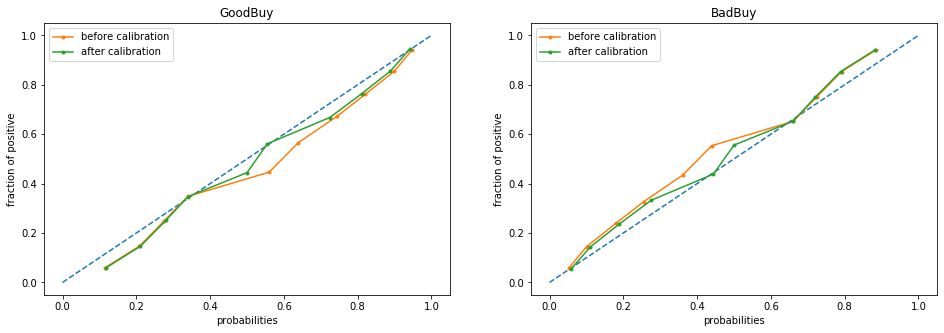

In [28]:
### PLOT RELIABILITY DIAGRAM ###

plt.figure(figsize=(16,5))

plt.subplot(121)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(acc_before[0], prob_before[0], marker='.', label='before calibration')
plt.plot(acc_after[0], prob_after[0], marker='.', label='after calibration')
plt.legend(); plt.title('GoodBuy'); plt.ylabel('fraction of positive'); plt.xlabel('probabilities')

plt.subplot(122)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(acc_before[1], prob_before[1], marker='.', label='before calibration')
plt.plot(acc_after[1], prob_after[1], marker='.', label='after calibration')
plt.legend(); plt.title('BadBuy'); plt.ylabel('fraction of positive'); plt.xlabel('probabilities')

In [29]:
### ECE SCORE FOR GOOD BUY AFTER CALIBRATION ###

ece_score(X_test_calib[:,0], acc_after[0], prob_after[0])

0.01921789725821237

In [30]:
### ECE SCORE FOR BAD BUY AFTER CALIBRATION ###

ece_score(X_test_calib[:,1], acc_after[1], prob_after[1])

0.019217889678130082